In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
sns.set_context('poster')
sns.set_palette('colorblind')

random_seed = 2021

### First, let's simulate the data we're going to fit!

In [2]:
m_true = 5
c_true = 10

x = np.linspace(0, 10, 100)
y = m_true * x + c_true
yerr = 6.

np.random.seed(random_seed)
y += np.random.randn(len(y))*yerr

Text(0, 0.5, 'y')

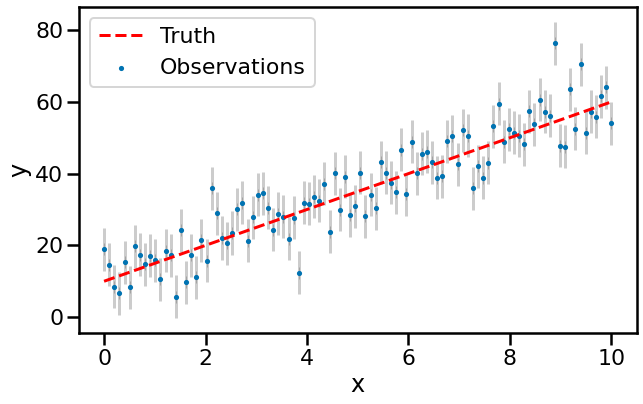

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, zorder=1, s=10, label='Observations')
ax.errorbar(x, y, yerr=yerr, alpha=.2, c='k', zorder=0, fmt='|')
ax.plot(x, m_true * x + c_true, ls='--', c='r', lw=3, label='Truth')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

Now, let's set up a PyStan script to model this line! We want to measure the parameters $m$ and $c$ that determine the slope and intercept of the line.

Somewhat counterintuitively, a PyStan model is actually written as a string object, which is then passed into the PyStan functions.

In [34]:
import stan as ps

model = """
data {
    // we need to define the data and their boundaries
    int<lower = 1> N;    // length of the data
    real x[N];    // x axis values
    real y[N];    // y axis values
    real yerr; // uncertainty
}
parameters {
    // we need to define the parameters and their boundaries
    real<lower=0> m;
    real c;
}
transformed parameters{
    real mod[N] = m * x + c;
}
model {
    // now we define the priors on each defined parameter
    
    m ~ uniform(1, 10);
    c ~ normal(10, 10);
    
    // and set up the likelihood function
    y ~ normal(mod, yerr);
}
"""

What we've set up here is a simple Bayesian model with two priors and a likelihood function. The priors are set up that $m$ has a uniform probability to be between 1 and 10. The intercept $c$ has a prior that is a normal distribution centered on 10 with a spread of 10 (which I'm guessing based on how the data look).

The `likelihood` line determines how the parameters (which have been defined by your priors) are evaluated against the data! In this case we use a normal distribution, with a mean that is set as your model, and standard deviation equal to the uncertainty on your observations.

In order to sample using PyStan, we need to set up a dictionary with our data first.

In [35]:
data = {"N" : len(x),
        "x" : x,
        "y" : y,
        "yerr" : yerr}

We now sample the model as follows:

In [36]:
# these two lines are required to fix a jupyter notebook bug here
import nest_asyncio
nest_asyncio.apply()

sm = ps.build(model, data = data)
fit = sm.sample()

Building...


Building: Semantic error:   -------------------------------------------------
    13:  }
    14:  transformed parameters{
    15:      real mod[N] = m * x + c;
                           ^
    16:  }
    17:  model {
   -------------------------------------------------

Ill-typed arguments supplied to infix operator *. Available signatures: 
(int, int) => int
(real, real) => real
(row_vector, vector) => real
(real, vector) => vector
(vector, real) => vector
(matrix, vector) => vector
(real, row_vector) => row_vector
(row_vector, real) => row_vector
(row_vector, matrix) => row_vector
(real, matrix) => matrix
(vector, row_vector) => matrix
(matrix, real) => matrix
(matrix, matrix) => matrix
Instead supplied arguments of incompatible type: real, array[] real.

ValueError: Semantic error

And this `traceplot` shows that the sampled posterior distributions look like nice normal distributions encompassing the true answer. Good!




Finally, we can look at the results using a `corner` plot, which is a very popular tool for studying the output of MCMC analyses. Essentially, it plots the samples drawn from the model, and so shows the correlations between the different parameters effecitvely.

In [ ]:
import corner

chain = np.array([trace['m'], trace['c']])
corner.corner(chain.T, labels=[r'$m$',r'$c$'], show_titles=True, 
              quantiles=[0.16, 0.5, 0.84], truths=[m_true, c_true])
plt.show()

You can see that the normal $68\%$ confidence interval (indicated by the dashed lines) contains the "truth" values--- our model has done a good job!

Finally, we can plot the draws of our model over the data to see how the data have informed our model.

In [ ]:
quantiles[0]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y, zorder=1, s=10, label='Observations')
ax.errorbar(x, y, yerr=yerr, alpha=.2, c='k', zorder=0, fmt='|')

linrange = np.linspace(0, 10, 100)
A = np.vander(linrange, 2)
lines = np.dot(chain.T, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(linrange, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5, zorder=10, label=r'$1\sigma$ fit')
ax.plot(linrange, m_true*linrange + c_true, c='k', zorder=1, alpha=1., ls='--', lw=5, label=r'$y = mx + b$')


ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc='upper left')
sns.despine()
fig.tight_layout()
plt.show()